Submisson by ajith shenoy(ajithshenoy19@gmail.com)

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
import pylab as py

In [ ]:
#utils

def build_statmodel_regressor(columns):
    """Function to build a model using statsmodel api"""
    X_train_sm = sm.add_constant(X_train[columns])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

def build_sklearn_regressor(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1


def get_vif(cols):

    """Function to calculate VIFs"""
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [ ]:
RANDOMSEED = 42

In [ ]:
#csv_url  = "https://ml-course2-upgrad.s3.amazonaws.com/Linear+Regression+Assignment/Bike+Sharing+Assignment/day.csv"
bike_share_data  =  pd.read_csv("day.csv",index_col=0)
display(bike_share_data.sample(3,random_state=42))
print(f'\nOut of {len(bike_share_data)} {bike_share_data.duplicated().sum()} records are duplicated\n')
print(bike_share_data.info())

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
469,14-04-2019,2,1,4,0,6,0,1,20.295000,24.39980,50.2917,12.791439,2795,4665,7460
149,29-05-2018,2,0,5,0,0,0,1,27.367500,30.77750,81.8750,14.333846,2355,2433,4788
303,30-10-2018,4,0,10,0,0,0,1,13.085847,16.06645,62.3750,11.833339,885,2446,3331



Out of 730 0 records are duplicated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB
None


Observations:
- There are no null / missing values in the dataset.
- No duplicates.
-  variables like 'mnth', weathersit' ,'season' and 'weekday' are int64 and need to be remapped.
- temp and atemp , could have high positive correlation and we'd need to investigate which to keep. If we keep atemp , we can drop hum and windspeed as they influence atemp (feel temperature).
- 'cnt' is the target variable which is the sum of casual and registered bike rentals. casual and registered columns can be dropped.
- 'dteday' can also be dropped as we already have year,month holiday features

### Mapping Columns and Dropping Redundant Columns

In [ ]:
# Maping month
bike_share_data['mnth'] = bike_share_data['mnth'].apply(lambda x: str.lower(calendar.month_abbr[x]))

# Maping seasons
bike_share_data['season'] = bike_share_data.season.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

# Mapping weathersit
bike_share_data['weathersit'] = bike_share_data.weathersit.map({1:'clear',2:'mist & cloudy',
                                             3:'light snow & rain',4:'heavy snow & rain'})
#Mapping Weekday
bike_share_data['weekday'] = bike_share_data.weekday.map({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})

bike_share_data.sample(3,random_state=RANDOMSEED)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
469,14-04-2019,summer,1,apr,0,sat,0,clear,20.295000,24.39980,50.2917,12.791439,2795,4665,7460
149,29-05-2018,summer,0,may,0,sun,0,clear,27.367500,30.77750,81.8750,14.333846,2355,2433,4788
303,30-10-2018,winter,0,oct,0,sun,0,clear,13.085847,16.06645,62.3750,11.833339,885,2446,3331


In [ ]:
#dropping redudant target variables and index column instant
bike_share_data.drop(columns=['dteday','registered','casual'],inplace=True)

### Discovering Patterns

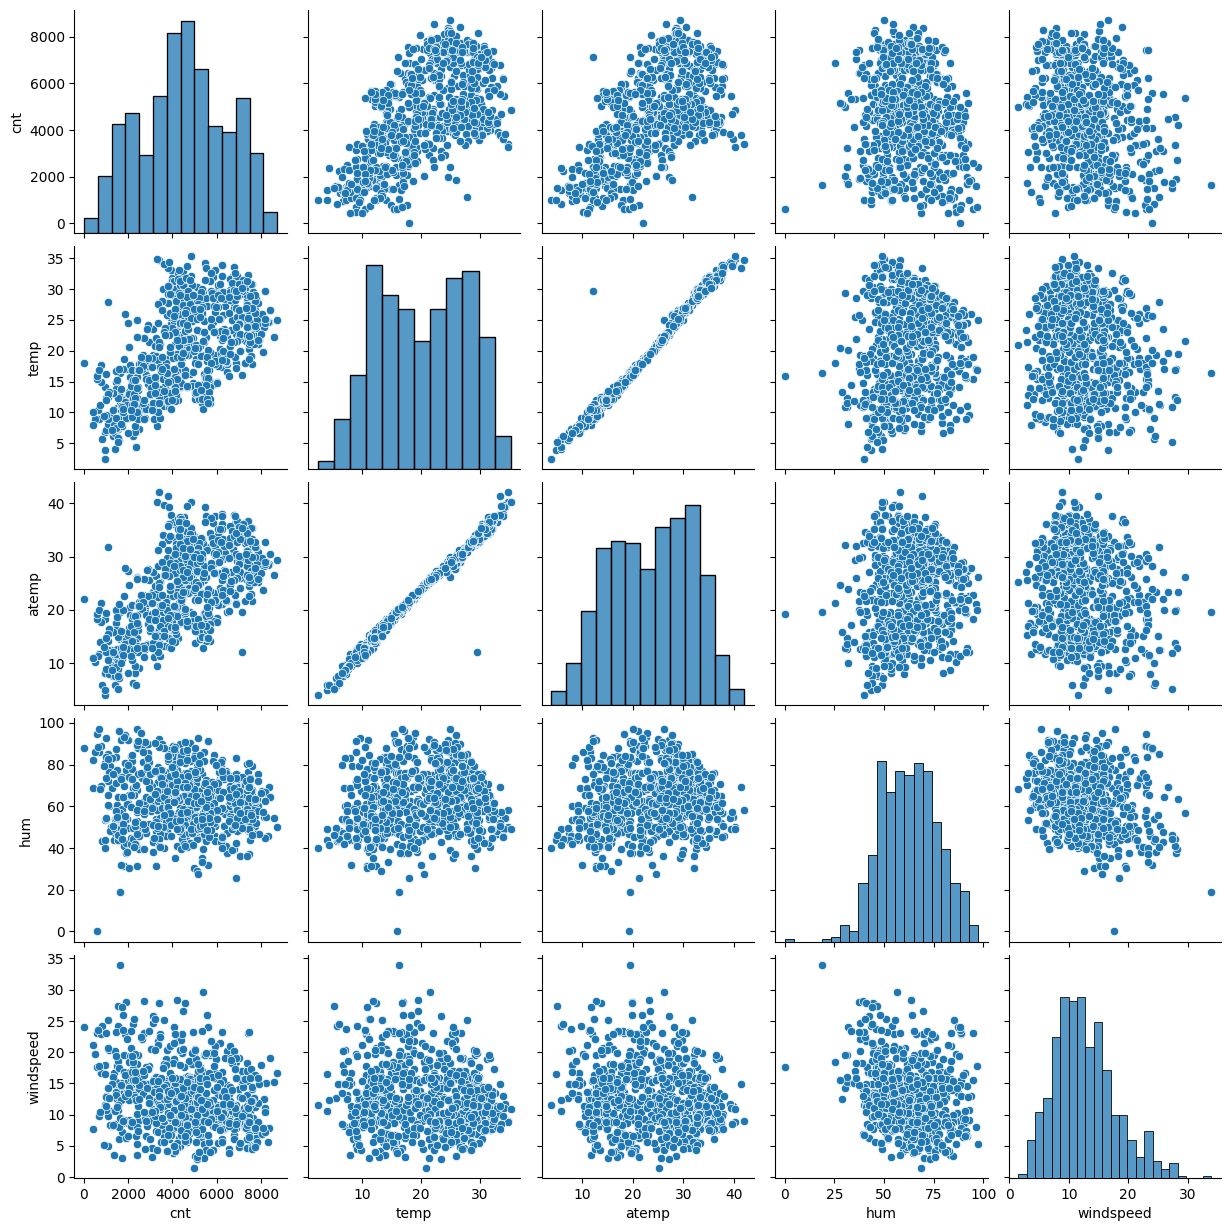

In [ ]:
# Visualising the Data
sns.pairplot(data = bike_share_data, vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

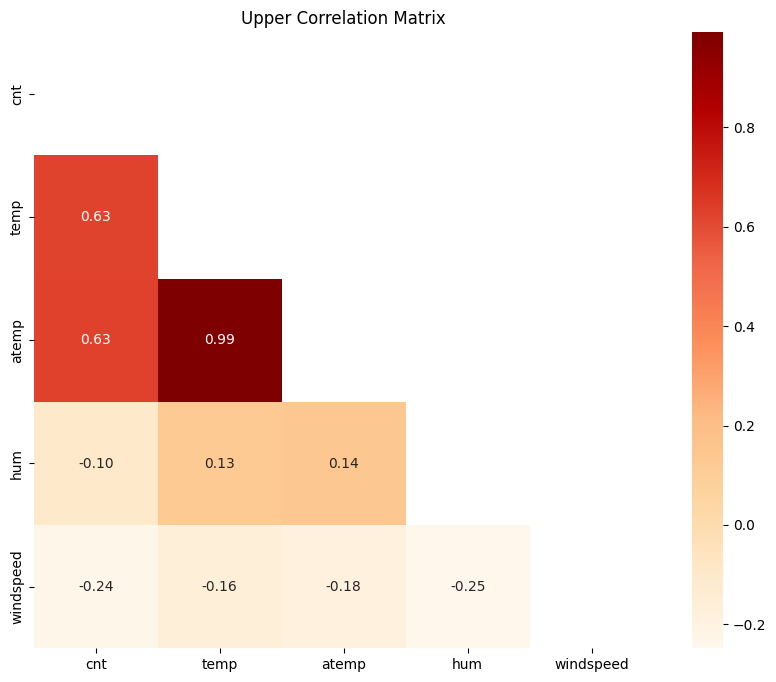

In [ ]:
# plotting upper triangular correlation matrix for easier readability
plt.figure(figsize=(10, 8))
correlation_matrix  = bike_share_data[['cnt', 'temp', 'atemp', 'hum','windspeed']].corr(numeric_only=True)
mask = np.triu(correlation_matrix)  # Create a mask for the lower triangle
sns.heatmap(correlation_matrix,mask=mask, annot=True,cmap='OrRd',fmt=".2f")
plt.title("Upper Correlation Matrix")
plt.show()

Observations from the plots above:
- Temperature has the highest corelation with the target variable , followed by year.
- windspeed and humidity seem to be weakly negatively correlated with respect to target variable.
- Temperature and Feel temperature seem to be almost perfectly correlated. I'll be dropping atemp , as it can be expressed as a relationship between temperature, humidity and windspeed.

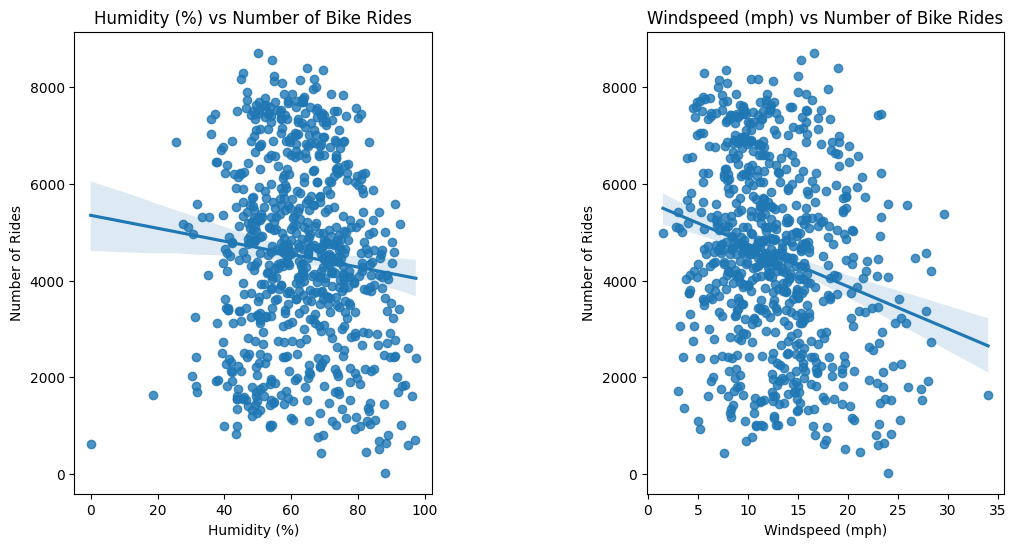

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Variables to plot
variables = [('hum', 'Humidity (%)'), ('windspeed', 'Windspeed (mph)')]

for i, (var, label) in enumerate(variables):
    sns.regplot(x=var, y='cnt', data=bike_share_data, ax=axes[i])
    axes[i].set_title(f'{label} vs Number of Bike Rides')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Number of Rides')

plt.subplots_adjust(wspace=0.6)
plt.show()

Observations:
- No direct correlation found between humidity and windspeed against Bike rides

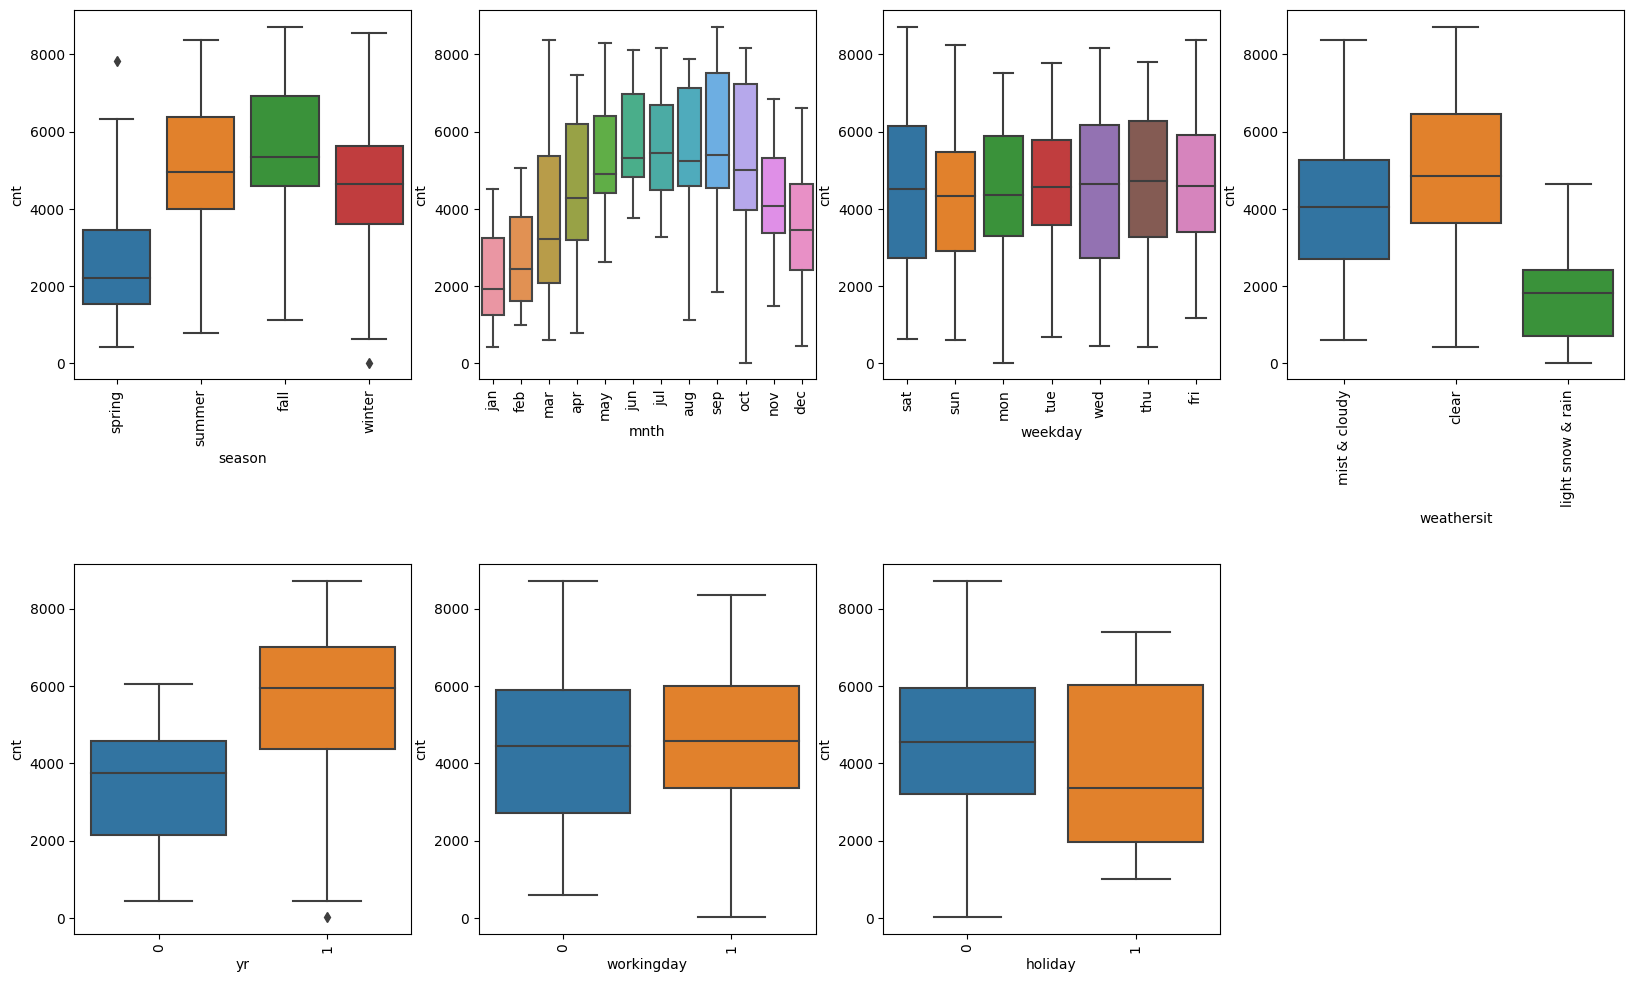

In [ ]:
#visualizing the categorical variables of the dataset using boxplot
features = ['season', 'mnth', 'weekday', 'weathersit', 'yr', 'workingday', 'holiday']

plt.figure(figsize=(20, 12))
for idx, feature in enumerate(features, start=1):
    plt.subplot(2, 4, idx)
    plt.xticks(rotation='vertical')
    sns.boxplot(x=feature, y='cnt', data=bike_share_data)

plt.subplots_adjust(hspace=0.5)
plt.show()

Observations from the plots:
- Bike rentals are popular during summer and fall.
- Not one single rental during weather condition "Heavy Snow & Rain".
- September and October witness the highest bike rental rates.
- More bikes are rented on Saturdays, Wednesdays, and Thursdays.
- Clear weather conditions see the highest bike rental activity.
- The year 2019 had a notable increase in bike rentals.
- Working day status or holidays doesn't significantly impact bike rental rates.

### Data Preparation and Preprocessing

#### Encoding Categorical variables

In [ ]:
# Checking Datatypes
bike_share_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 74.1+ KB


In [ ]:
# dummy encoding categorical variables
categorical_columns = ['mnth', 'weekday', 'weathersit', 'season']

# Create dummy variables for the specified columns
dummies = pd.get_dummies(bike_share_data[categorical_columns], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
bike_share_data = pd.concat([bike_share_data, dummies], axis=1)

# Drop the original categorical columns
bike_share_data.drop(categorical_columns, axis=1, inplace=True)
print(f"\ntotal records and features: {bike_share_data.shape}\n")
bike_share_data.sample(3,random_state=RANDOMSEED)


total records and features: (730, 30)



,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light snow & rain,weathersit_mist & cloudy,season_spring,season_summer,season_winter
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
469,1,0,0,20.295000,24.39980,50.2917,12.791439,7460,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
149,0,0,0,27.367500,30.77750,81.8750,14.333846,4788,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
303,0,0,0,13.085847,16.06645,62.3750,11.833339,3331,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


#### Train Test Split

In [ ]:
TARGET  = 'cnt'

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(bike_share_data.drop(columns=['atemp',TARGET]),bike_share_data[TARGET],train_size=0.7, random_state=RANDOMSEED)
print(X_train.shape,X_test.shape)
print(X_train.info())

(510, 28) (220, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 646 to 103
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   yr                            510 non-null    int64  
 1   holiday                       510 non-null    int64  
 2   workingday                    510 non-null    int64  
 3   temp                          510 non-null    float64
 4   hum                           510 non-null    float64
 5   windspeed                     510 non-null    float64
 6   mnth_aug                      510 non-null    uint8  
 7   mnth_dec                      510 non-null    uint8  
 8   mnth_feb                      510 non-null    uint8  
 9   mnth_jan                      510 non-null    uint8  
 10  mnth_jul                      510 non-null    uint8  
 11  mnth_jun                      510 non-null    uint8  
 12  mnth_mar                      510 non-null

#### Scaling
- Using min-max scaler as a lot of varaibles are binary variables.

In [ ]:
variables_to_scale = ['hum','windspeed','temp']

scaler = MinMaxScaler()
X_train[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])
X_test[variables_to_scale] = scaler.transform(X_test[variables_to_scale])
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,mnth_aug,mnth_dec,mnth_feb,mnth_jan,mnth_jul,mnth_jun,mnth_mar,mnth_may,mnth_nov,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light snow & rain,weathersit_mist & cloudy,season_spring,season_summer,season_winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000
mean,0.519608,0.027451,0.668627,0.551313,0.654203,0.415045,0.074510,0.074510,0.074510,0.088235,0.092157,0.084314,0.062745,0.092157,0.090196,0.090196,0.090196,0.149020,0.150980,0.152941,0.145098,0.131373,0.141176,0.029412,0.345098,0.231373,0.258824,0.24902
std,0.500106,0.163554,0.471169,0.227237,0.143788,0.185760,0.262857,0.262857,0.262857,0.283915,0.289531,0.278131,0.242742,0.289531,0.286744,0.286744,0.286744,0.356457,0.358381,0.360284,0.352545,0.338139,0.348545,0.169124,0.475867,0.422124,0.438419,0.43287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.354526,0.544033,0.281934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,0.000000,1.000000,0.575824,0.660798,0.384737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,0.000000,1.000000,0.745338,0.756977,0.526489,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Build a Model using RFE and manual intervention
- Use RFE to eliminate some columns

In [ ]:
# Build a Lienar Regression model using SKLearn for RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

#Cut down number of features to 14 using automated approach
rfe = RFE(estimator=lr,n_features_to_select=14)
rfe.fit(X_train,y_train)
retained_columns = list(X_train.columns[rfe.support_])
print(f"Features remaining after RFE:{retained_columns}")

Features remaining after RFE:['yr', 'temp', 'hum', 'windspeed', 'mnth_dec', 'mnth_jul', 'mnth_mar', 'mnth_nov', 'mnth_sep', 'weekday_sat', 'weathersit_light snow & rain', 'weathersit_mist & cloudy', 'season_spring', 'season_winter']


Model 1

In [ ]:
build_statmodel_regressor(retained_columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     182.7
Date:                Mon, 11 Sep 2023   Prob (F-statistic):          3.34e-185
Time:                        10:17:39   Log-Likelihood:                -4120.1
No. Observations:                 510   AIC:                             8270.
Df Residuals:                     495   BIC:                             8334.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

- "weekday_sat" will be removed as it has a p-value higher than 0.005

Model 2

In [ ]:
retained_columns.remove("weekday_sat") # removing the high p value column
build_statmodel_regressor(retained_columns)

#checking for multicolinearity
get_vif(retained_columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     196.1
Date:                Mon, 11 Sep 2023   Prob (F-statistic):          7.00e-186
Time:                        10:17:39   Log-Likelihood:                -4121.3
No. Observations:                 510   AIC:                             8271.
Df Residuals:                     496   BIC:                             8330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

- Model 2 has all p-values within range ,F-statistic has improved.
- Humidity has high VIF and will be removed.

Model 3

In [ ]:
retained_columns.remove("hum") # removing the high VIF column
build_statmodel_regressor(retained_columns)

#checking for multicolinearity
get_vif(retained_columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Mon, 11 Sep 2023   Prob (F-statistic):          1.04e-183
Time:                        10:17:40   Log-Likelihood:                -4129.2
No. Observations:                 510   AIC:                             8284.
Df Residuals:                     497   BIC:                             8339.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

- Model 3 seems to be the right model as it has no insignificant variables (based on p-values) and no issues of multicolinearity.

In [ ]:
final_lr_model = build_sklearn_regressor(X_train[retained_columns],y_train)

#getting predictions
y_train_pred = final_lr_model.predict(X_train[retained_columns])
y_test_pred = final_lr_model.predict(X_test[retained_columns])

### Checking The Assumptions of MLR

 Mean of residuals : -2.1399875335833605e-14



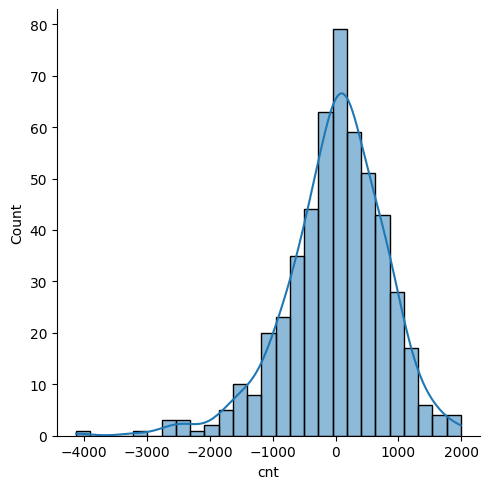

In [ ]:
#residual analysis
train_residuals = y_train - y_train_pred
print(f" Mean of residuals : {train_residuals.mean()}\n")
sns.displot(train_residuals,kde=True)
plt.show()

- Mean of residuals is extremly small (0) as expected.

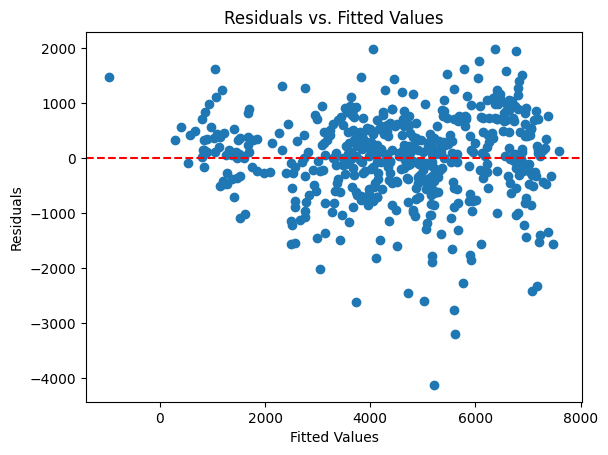

In [ ]:
QQ = ProbPlot(train_residuals)

# Scatterplot
plt.scatter(y_train_pred, train_residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

-  No sings of Heteroskedasticity

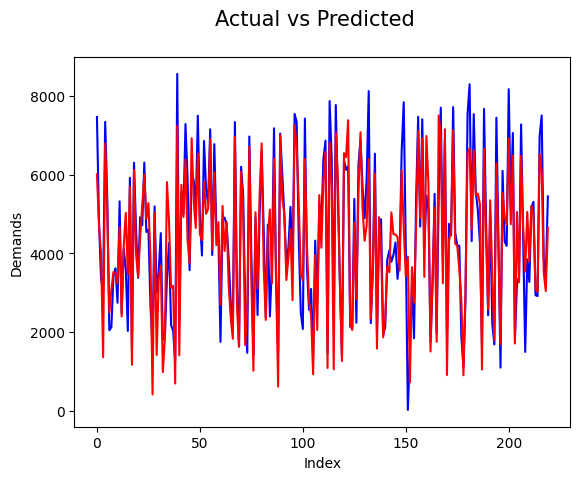

In [ ]:
# Actual vs Predicted
c = [i for i in range(0,len(X_test),1)]
plt.plot(c,y_test, color="blue")
plt.plot(c,y_test_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

- Predictions are very close to actuals

#### Model Evaluation

In [ ]:
r2_score(y_test, y_test_pred)

0.8173900166954571

### Model Interpretation and Business Recommendation

In [ ]:
build_statmodel_regressor(retained_columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Mon, 11 Sep 2023   Prob (F-statistic):          1.04e-183
Time:                        11:45:01   Log-Likelihood:                -4129.2
No. Observations:                 510   AIC:                             8284.
Df Residuals:                     497   BIC:                             8339.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Model Interpretation


- Year (yr): has the highest positive coefficient (1999.64), indicating its significant importance. Each additional year leads to a substantial increase in bike rentals.

- Temperature (temp): also has a strong positive influence on rentals, with a coefficient of 3414.61. Warmer temperatures result in more bike rentals.

- Weather Conditions: Both 'weathersit_light snow & rain' and 'weathersit_mist & cloudy' have negative coefficients, emphasizing their importance. Adverse weather conditions significantly reduce bike rentals.
- Seasons: 'season_spring' has a notable negative coefficient (-1360.52), indicating that spring has lower rentals compared to the reference season. In contrast, 'season_winter' has a positive coefficient (707.81), signaling higher rentals in winter.

- Months: Several months have significant coefficients, both positive and negative. For example, 'mnth_mar' and 'mnth_nov' have positive coefficients, suggesting higher rentals during these months. In contrast, 'mnth_dec' and 'mnth_jul' have negative coefficients, indicating lower rentals.

- Wind Speed (windspeed): Wind speed has a negative coefficient (-775.36), showing that higher wind speeds deter bike rentals.

#### Busniess Recommendations:

- Focus on Seasonal Strategies: The company should tailor its marketing and bike availability strategies based on the season. Expand marketing efforts during spring to attract more customers. Winter seems to be a strong season for rentals, so capitalizing on this demand is crucial.

- Weather-Based Strategies: Consider offering special promotions or maintenance services during periods of light snow, rain, or misty and cloudy weather to mitigate the impact of weather conditions on rentals.

- Yearly Growth: The company should expect an annual growth in bike rentals, as indicated by the 'yr' coefficient. Plan for expansion and capacity increases accordingly.

- Temperature Matters: Higher temperatures drive more bike rentals. Plan for increased bike availability and promotions during warmer months.

- Month-Specific Promotions: Design marketing campaigns that target months with positive coefficients ('mnth_mar' and 'mnth_nov'), and be prepared for lower demand during months with negative coefficients ('mnth_dec' and 'mnth_jul').